### Question 2: Life-Cycle Model with Dynamic Programming

For the law of motion we have $W + \tilde{y} = c + a$ and $W' = (1+r)a$. We may combine these and get 

$$c = W + \tilde{y} - \frac{W'}{1+r}.$$

Thus, we want to solve the following system of Bellman equations for all $t \in \{1, \dots, 60\}$ via backward induction:

$$V_t(W) = \max_{W'}\left\{ log(W + \tilde{y_t} - \frac{W'}{1+r}) + \beta V_{t+1}(W')\right\} \text{, where} \space \tilde{y_t} = \begin{cases} 
y & \text{if } t \leq 40 \\ 
0 & \text{if } 41 \leq t \leq 60.
\end{cases}$$

As preferences are monotonic, the household will choose $W' = 0$ in the terminal period $T=60$. That is, all remaining wealth is consumed in period $60$ and we have $V_{60} = log(W_{60})$ and $V_{61} = 0$. From this condition, we then start the backward induction procedure.

The following parameters are used:
- $y=0.5$
- $\beta = 0.9$
- $r=0.1$

#### 1. Solve for value & policy functions

In [99]:
function solve_lifecycle(y, β, r, T1, T2, preferences)

    # Wealth grid
    N = 401
    W_grid = range(-2, 6, length=N)

    T_total = T1 + T2

    # Income vector
    y_life_stream = [fill(0.5, T1); fill(0.0, T2)]
    y_reversed = reverse(y_life_stream) # Reverse for backward induction

    u(c) = preferences(c)

    # Matrices
    # Rows -> Time (periods left to live), Columns -> Wealth Grid Points
    # Row 1 corresponds to *last* period of life (T=60)
    ValueFun = zeros(T_total, N) # system of value functions
    Pol_C = zeros(T_total, N)       # Policy for Consumption
    Pol_W_next = zeros(T_total, N)  # Policy for Next Wealth 
    Pol_W_idx = zeros(Int, T_total, N) # Policy for Next Wealth (grid index)

    # Set income for terminal period
    current_y = y_reversed[1]

    # apply terminal condition
    # ie for any wealth level, consume all as household is dead next period
    for i in 1:N
        W_current = W_grid[i]
        c = W_current + current_y
        
        ValueFun[1, i] = u(c)
        Pol_C[1, i] = c
        Pol_W_next[1, i] = 0.0 # No savings after death
        # We map 0.0 to the closest index for consistency, though it doesn't matter for V
        Pol_W_idx[1, i] = findmin(abs.(W_grid .- 0.0))[2] 
    end

    # backward induction
    for t in 2:T_total
        current_y = y_reversed[t]
        
        # Loop over all current wealth levels 
        # For each current wealth, find optimal next period wealth
        for i in 1:N
            W_current = W_grid[i]
            
            # now calculate consumption for all the possible next period wealth choices (W_next)

            resources = W_current + current_y
            save_today = W_grid ./ (1 + r)  # possible savings today to achieve W_next
            c_candidates = resources .- save_today
            
            # get utility for all candidates + discounted future value
            # we know the value function at this point from the previous iteration (ie t-1)
            val_candidates = u.(c_candidates) + β .* ValueFun[t-1, :]
            
            # now simply find the maximum value and corresponding index
            max_val, max_idx = findmax(val_candidates)

            ValueFun[t, i] = max_val
            Pol_W_idx[t, i] = max_idx
            Pol_W_next[t, i] = W_grid[max_idx]
            Pol_C[t, i] = c_candidates[max_idx]
        end
    end

    # reverse to normal order
    V_chronological = reverse(ValueFun, dims=1)
    C_chronological = reverse(Pol_C, dims=1)
    W_chronological = reverse(Pol_W_next, dims=1)
    W_idx_chronological = reverse(Pol_W_idx, dims=1)

    return V_chronological, C_chronological, W_chronological, W_idx_chronological, W_grid
end

solve_lifecycle (generic function with 1 method)

In [100]:
# Parameters
y = 0.5               # Income during working periods
β = 0.9                 # Discount factor
r = 0.1                 # Interest rate

working_periods = 40
retirement_periods = 20

preferences = function(c)
    if c > 0
        return log(c)
    else
        return -Inf
    end 
end

V_chronological, C_chronological, W_chronological, W_idx_chronological, W_grid = solve_lifecycle(y, β, r, working_periods, retirement_periods, preferences)

([-11.714850044332795 -11.653889344543108 … 0.3965278299572461 0.4140629531852644; -11.744130822255325 -11.683170122465638 … 0.3885366000985373 0.40608241960125463; … ; -Inf -Inf … 2.169429909096026 2.17577181562131; -Inf -Inf … 1.7884205679625405 1.791759469228055], [0.31818181818181807 0.3381818181818181 … 1.1345454545454559 1.136363636363637; 0.31818181818181807 0.3381818181818181 … 1.1345454545454559 1.136363636363637; … ; -0.18181818181818193 -0.16181818181818192 … 3.143636363636364 3.1636363636363636; -2.0 -1.98 … 5.98 6.0], [-2.0 -2.0 … 5.88 5.9; -2.0 -2.0 … 5.88 5.9; … ; -2.0 -2.0 … 3.12 3.12; 0.0 0.0 … 0.0 0.0], [1 1 … 395 396; 1 1 … 395 396; … ; 1 1 … 257 257; 101 101 … 101 101], -2.0:0.02:6.0)

#### 2. Policy functions for different age levels

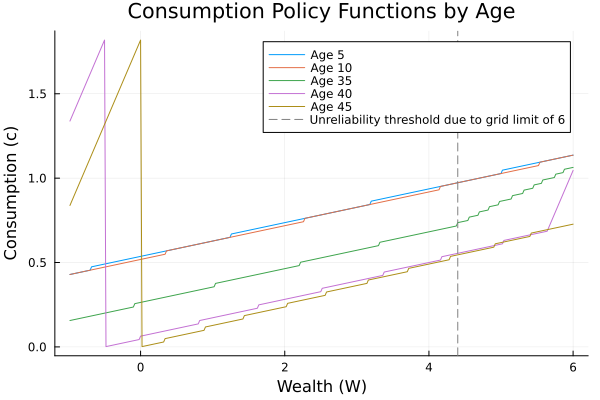

In [101]:
using Plots

ages_to_plot = [5, 10, 35, 40, 45]

# filter for wealth > -1
W_subset = W_grid[W_grid .> -1]

# plot
p = plot(title = "Consumption Policy Functions by Age",
         xlabel = "Wealth (W)",
         ylabel = "Consumption (c)",
         legend = :topright
)

# Plot policy functions for ages
for age in ages_to_plot
    c_data = C_chronological[age, W_grid .> -1]
    plot!(p, W_subset, c_data, label = "Age $age")
end

# because we had to limit grid to W <= 6, we have inaccuracies for high wealth values
# the non-linearities of the policy functions for ages 35 and 40 do not sustain
# if one expands grid
vline!(p, [4.4], line=(:dash, :gray), label="Unreliability threshold due to grid limit of 6")

display(p)

Note that for large values of $W$ the policy function is not accurate for all ages as we limited the grid size to 6, as required in the question.

Secondly, for values $W<0$ we observe a discontinuity for the policy functions for ages 40 and 45. This can be explained because these agents enter the period with debt and will never earn income again (i.e. age $\geq40$). Thus, they cannot satify their lifetime budget constraint without having something like negative consumption. This leads to $u(c)$ assigning -Inf as we defined and in this case findmax() will mechanically choose the first index. Thus, these parts of the functions have no real meaning.

#### Write function for simulations for 3. and 4.

In [102]:
function simulate_lifecycle(W_initial, T1, T2, C_chronological, W_chronological, W_idx_chronological, W_grid)

    T_total = T1 + T2

    W_path = zeros(T_total + 1)
    C_path = zeros(T_total)
    W_path[1] = W_initial

    # get initial index
    _, current_idx = findmin(abs.(W_grid .- W_path[1]))

    for t in 1:T_total
        # get consumption and next wealth for this wealth index
        C_path[t] = C_chronological[t, current_idx]
        W_path[t+1] = W_chronological[t, current_idx]
        
        # update index for next period
        current_idx = W_idx_chronological[t, current_idx]
    end
    return W_path, C_path
end

simulate_lifecycle (generic function with 2 methods)

#### 3. Simulation with zero initial wealth

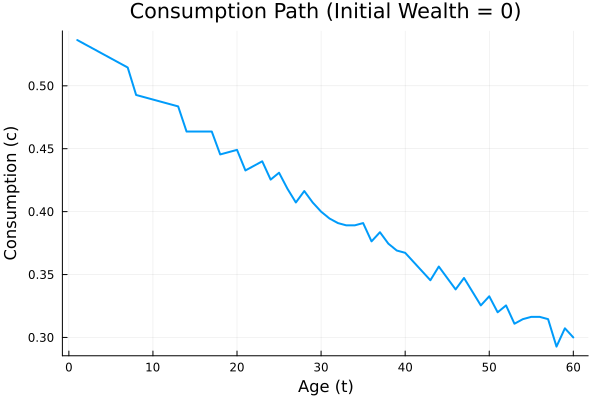

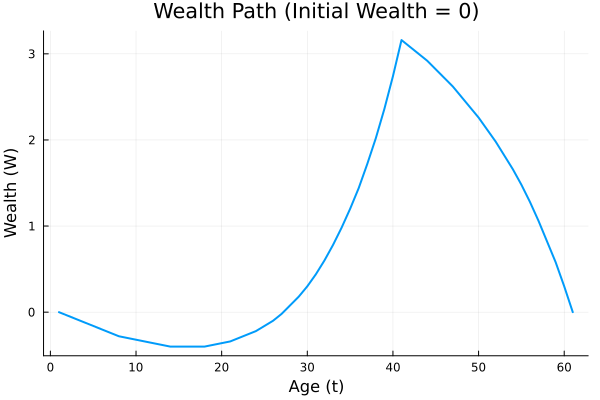

In [103]:
# Simulation with zero initial wealth
W_path_0, C_path_0 = simulate_lifecycle(0, working_periods, retirement_periods, C_chronological, W_chronological, W_idx_chronological, W_grid)

# Consumption
p_c_0 = plot(1:(working_periods + retirement_periods), C_path_0, 
    title = "Consumption Path (Initial Wealth = 0)", 
    xlabel = "Age (t)", 
    ylabel = "Consumption (c)", 
    legend = false,
    linewidth = 2)

display(p_c_0)


# Wealth
p_w_0 = plot(1:(working_periods + retirement_periods + 1), W_path_0, 
    title = "Wealth Path (Initial Wealth = 0)", 
    xlabel = "Age (t)", 
    ylabel = "Wealth (W)", 
    legend = false,
    linewidth = 2)

display(p_w_0)

#### 4. Simulation with initial wealth of 1

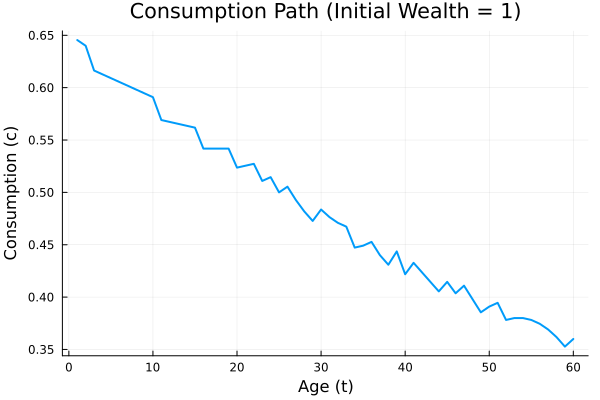

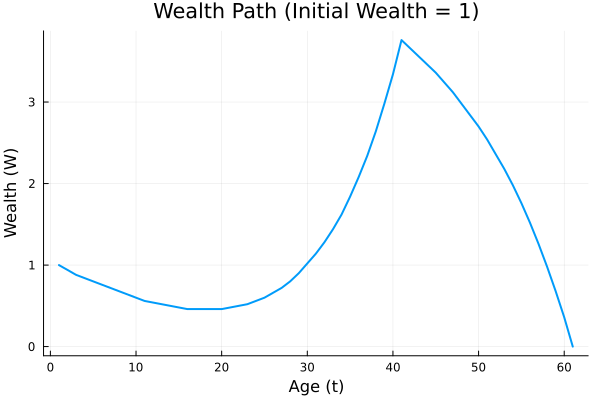

In [104]:
# Simulation with initial wealth of 1
W_path_1, C_path_1 = simulate_lifecycle(1)

# Consumption
p_c_1 = plot(1:T_total, C_path_1, 
    title = "Consumption Path (Initial Wealth = 1)", 
    xlabel = "Age (t)", 
    ylabel = "Consumption (c)", 
    legend = false,
    linewidth = 2)

display(p_c_1)

# Wealth
p_w_1 = plot(1:(T_total + 1), W_path_1, 
    title = "Wealth Path (Initial Wealth = 1)", 
    xlabel = "Age (t)", 
    ylabel = "Wealth (W)", 
    legend = false,
    linewidth = 2)

display(p_w_1)

#### 5. Simulate for $T_2 = 25$ and zero initial wealth

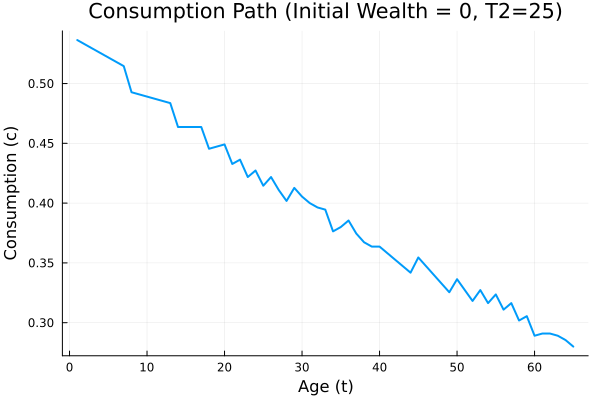

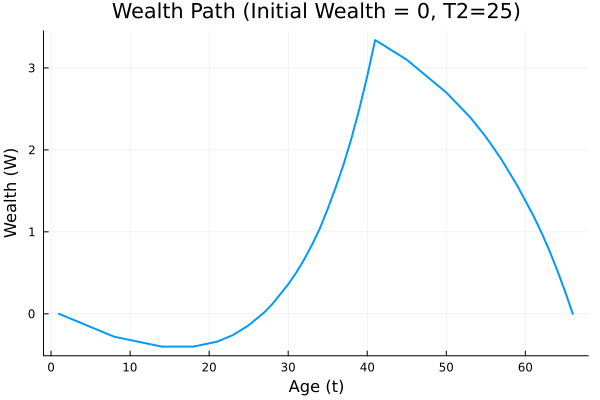

In [105]:
# need to solve lifecycle problem again with T2 = 25

retirement_periods_exp = 25

V_chronological_exp, C_chronological_exp, W_chronological_exp, W_idx_chronological_exp, W_grid_exp = solve_lifecycle(y, β, r, T1, retirement_periods_exp, preferences)

# simulate_indices
W_path_exp, C_path_exp = simulate_lifecycle(0, working_periods, retirement_periods_exp, C_chronological_exp, W_chronological_exp, W_idx_chronological_exp, W_grid_exp)

# Plot as before
# Consumption
p_c_exp = plot(1:(working_periods + retirement_periods_exp), C_path_exp, 
    title = "Consumption Path (Initial Wealth = 0, T2=25)", 
    xlabel = "Age (t)", 
    ylabel = "Consumption (c)", 
    legend = false,
    linewidth = 2) 

display(p_c_exp)

# Wealth
p_w_exp = plot(1:(working_periods + retirement_periods_exp + 1), W_path_exp, 
    title = "Wealth Path (Initial Wealth = 0, T2=25)", 
    xlabel = "Age (t)", 
    ylabel = "Wealth (W)", 
    legend = false,
    linewidth = 2)
    
display(p_w_exp)


#### 6. Different preferences

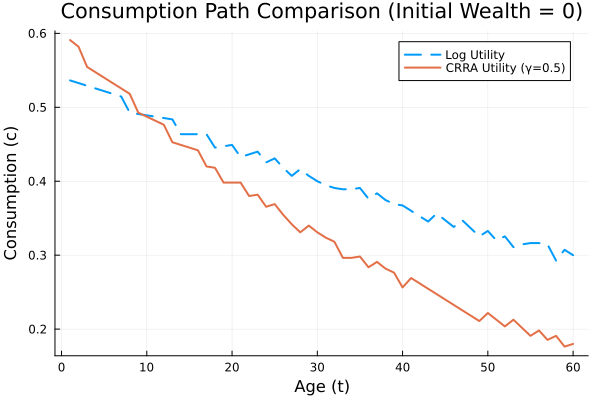

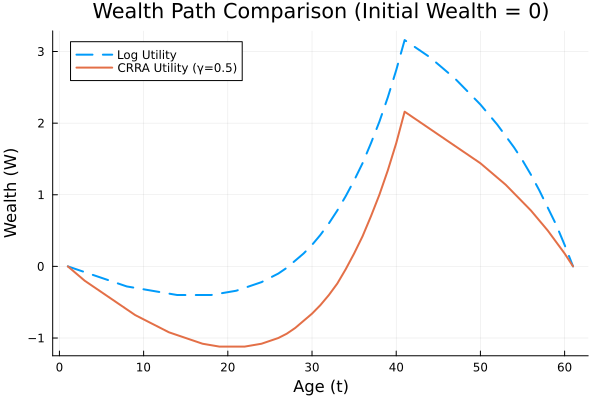

In [106]:
# define new utility function with 

# crra utility with γ = 0.5

γ = 0.5

preferences_alt = function(c)
    if c > 0
        return (c^(1-γ) - 1) / (1-γ)
    else
        return -Inf
    end 
end

V_chronological_alt, C_chronological_alt, W_chronological_alt, W_idx_chronological_alt, W_grid_alt = solve_lifecycle(y, β, r, working_periods, retirement_periods, preferences_alt)

# simulate
W_path_alt, C_path_alt = simulate_lifecycle(0, working_periods, retirement_periods, C_chronological_alt, W_chronological_alt, W_idx_chronological_alt, W_grid_alt)

# plot consumption and wealth paths as before
# and compare to log utility case in same plots

# Consumption
p_c_alt = plot(1:(working_periods + retirement_periods), C_path_0,
    title = "Consumption Path Comparison (Initial Wealth = 0)",
    xlabel = "Age (t)",
    ylabel = "Consumption (c)",
    legend = :topright,
    linewidth = 2,
    linestyle = :dash,
    label = "Log Utility")

plot!(p_c_alt, 1:(working_periods + retirement_periods), C_path_alt,
    label = "CRRA Utility (γ=0.5)", linewidth = 2)
display(p_c_alt)

# Wealth
p_w_alt = plot(1:(working_periods + retirement_periods + 1), W_path_0,
    title = "Wealth Path Comparison (Initial Wealth = 0)",
    xlabel = "Age (t)",
    ylabel = "Wealth (W)",
    legend = :topleft,
    linewidth = 2,
    linestyle = :dash,
    label = "Log Utility")

plot!(p_w_alt, 1:(working_periods + retirement_periods + 1), W_path_alt,
    label = "CRRA Utility (γ=0.5)", linewidth = 2)
display(p_w_alt)



We can observe a steeper consumption path over the lifecycle for the CRRA utility with $\gamma = 0.5$ compared to log utility (i.e. $\gamma \to 1$). This is because for this utility function $1/\gamma$ is the intertemporal elasticity of substitution (IES). Thus, if $\gamma$ is lower we have that IES is higher and so the agent is more willing to substitute intertemporally. And since we have $\beta (1+r)=0.99 < 1$, this implies that this substitution leads to more consumption being 'front-loaded' with higher IES.

#### 7. Change of interest rate

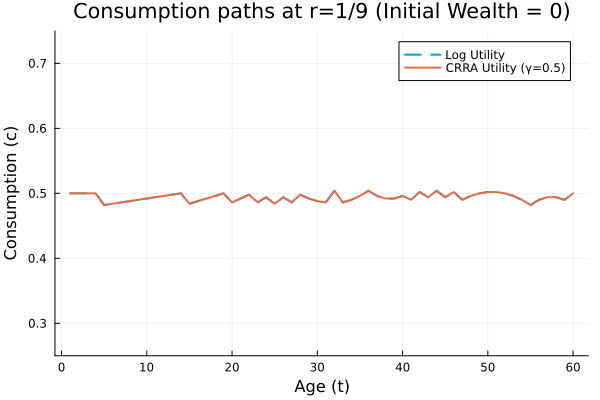

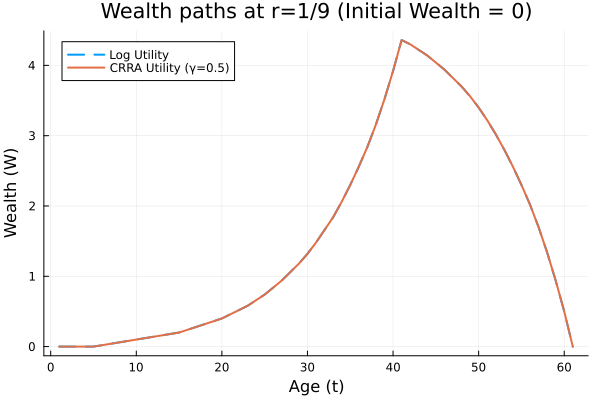

In [107]:
r_new = 1/9

# solve for both utility functions again with new interest rate

# log utility
V_chronological_r, C_chronological_r, W_chronological_r, W_idx_chronological_r, W_grid_r = solve_lifecycle(y, β, r_new, working_periods, retirement_periods, preferences)
# simulate
W_path_r, C_path_r = simulate_lifecycle(0, working_periods, retirement_periods, C_chronological_r, W_chronological_r, W_idx_chronological_r, W_grid_r)

# crra with γ = 0.5
V_chronological_r_alt, C_chronological_r_alt, W_chronological_r_alt, W_idx_chronological_r_alt, W_grid_r_alt = solve_lifecycle(y, β, r_new, working_periods, retirement_periods, preferences_alt)
# simulate
W_path_r_alt, C_path_r_alt = simulate_lifecycle(0, working_periods, retirement_periods, C_chronological_r_alt, W_chronological_r_alt, W_idx_chronological_r_alt, W_grid_r_alt)


# compare consumption paths for both utility functions at new interest rate
# Consumption
p_c_r = plot(1:(working_periods + retirement_periods), C_path_r,
    title = "Consumption paths at r=1/9 (Initial Wealth = 0)",
    xlabel = "Age (t)",
    ylabel = "Consumption (c)",
    legend = :topright,
    linewidth = 2,
    linestyle = :dash,
    label = "Log Utility",
    ylims = (0.25, 0.75)) 
plot!(p_c_r, 1:(working_periods + retirement_periods), C_path_r_alt,
    label = "CRRA Utility (γ=0.5)", linewidth = 2)
display(p_c_r)

# Wealth
p_w_r = plot(1:(working_periods + retirement_periods + 1), W_path_r,
    title = "Wealth paths at r=1/9 (Initial Wealth = 0)",
    xlabel = "Age (t)",
    ylabel = "Wealth (W)",
    legend = :topleft,
    linewidth = 2,
    linestyle = :dash,
    label = "Log Utility")
plot!(p_w_r, 1:(working_periods + retirement_periods + 1), W_path_r_alt,
    label = "CRRA Utility (γ=0.5)", linewidth = 2)
display(p_w_r)

We see that the consumption and wealth paths are identical for both utility specifications. In particular, the consumption path is stable over time (ignoring the effects due to the discrete grid). This is because we now have that $\beta (1+r) = 0.9(1+1/9) = 1$. That is, interest rate and discount factor perfectly balance each other out and consumption growth is zero at any point in time, as can be seen from the euler equation.